In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import fftpack
import matplotlib.gridspec as gridspec
import animatplot as amp
from matplotlib.lines import Line2D

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_green = '#708238'

colormap = matplotlib.colormaps.get_cmap('coolwarm')
colormap_aux = matplotlib.colormaps.get_cmap('tab10')

In [3]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ising_2d_lig(n_sims,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    # initialise
    state = np.random.choice(np.array([-1.,1.]),size=(L,L))

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

/tmp/ipykernel_3190891/44413780.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


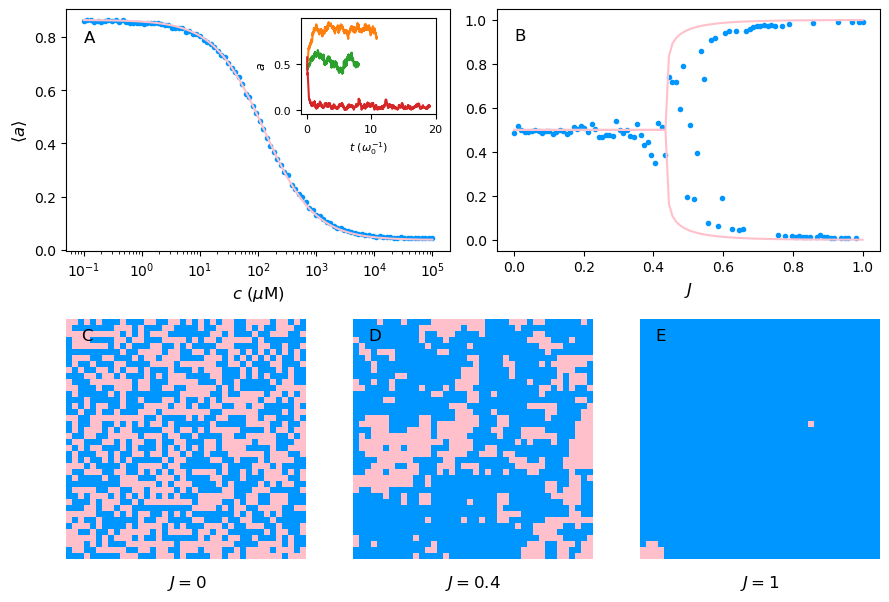

In [4]:
# show benchmark results in one figure
#n_sims = 10**4
n_sims = 10**4
L = 10

# preparation
fig = plt.figure(figsize=(9,12))

# create subplots
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])

# create inset
left, bottom, width, height = [0.34, 0.9, 0.15, 0.08]
axx = fig.add_axes([left, bottom, width, height])

ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:])

#################
## No coupling ##
#################

# prep
J = 0
c_arr = np.logspace(-1,5,10**2)
all_avg_spin = np.empty(c_arr.size)
color_counter = 1

# loop through various concentrations
for i,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[4000:])
    
    # plot realisations in the inset for some exemplars
    if i % 49 == 0:
        axx.plot(np.cumsum(waiting_times)[:800],0.5 + 0.5*avg_spin[:800],color=colormap_aux(color_counter))
        color_counter += 1
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
ax1.semilogx(c_arr,all_avg_act,'.',label='Simulation',color='#0096FF')
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory',color='#FFC0CB',alpha=1)
ax1.set_xlabel(r'$c$ ($\mu$M)',size=12)
ax1.set_ylabel(r'$\langle a \rangle$',size=12)
ax1.text(10**-1,0.78,'A',size=12)

# inset formatting
axx.set_xlabel(r'$t$ $(\omega_0^{-1})$',size=8)
axx.set_ylabel(r'$a$',size=9)
axx.tick_params(axis='both', which='major', labelsize=8)

######################
## Phase transition ##
######################

# preparation
J_arr = np.linspace(0,1,10**2)
c = 100
all_avg_spin = np.empty(J_arr.size)

# loop through various concentrations
for i,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[4000:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin

# theoretical result for an infinite system
def theoretical_act(J,Jcrit=0.5*np.log(1+np.sqrt(2))):
    return np.piecewise(J, [J < Jcrit, J >= Jcrit], [0.5, lambda J: 0.5 + 0.5*((1 - (np.sinh(2*J))**-4)**(1/8))])

# show results
ax2.plot(J_arr,all_avg_act,'.',label='Simulation',color='#0096FF')
ax2.plot(J_arr,theoretical_act(J_arr),color='#FFC0CB')
ax2.plot(J_arr,1-theoretical_act(J_arr),color='#FFC0CB',alpha=1)
ax2.set_xlabel(r'$J$',size=12)
ax2.text(0,0.91,'B',size=12)

##########################
## Spatial organisation ##
##########################

# formatting
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()

# parameters
n_sims = 5*10**4
L = 40
c = 100
J_list = [0,0.4,1]

# for formatting
text_list = ['C','D','E']
cmap = matplotlib.colors.ListedColormap(['#FFC0CB','#0096FF'])

for i,ax in enumerate((ax3, ax4, ax5)):
    # obtain data and show lattice
    spins,_ = ising_2d_lig(n_sims,L,J_list[i],cbase=c)
    ax.imshow(0.5 + 0.5*spins[-1,:,:],cmap=cmap)
    ax.set_title(f'$J={J_list[i]}$', y=-0.15, size=12)
    ax.text(2,3,text_list[i],size=12)

plt.tight_layout()
plt.margins(x=0,y=0)
plt.show()

In [4]:
# function that implements dynamic Ising model using Gillespie's algorithm
@numba.jit(nopython=True)
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [5]:
# self-consistency relation
def scr(m,J,c,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return m-np.tanh(q*J*m + H)

# function for calculating the theoretical ratio based on a mean-field theory
def ratio_mfa(J,c,N,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    # this solves the self-consistency relation
    roots = fsolve(scr,[-1,0,1],args=(J,c))
    
    # extract only the outer two solutions
    m_min = roots[0]
    m_plus = roots[-1]
    
    # calculate ratio using analytical expression if two distinct nonzero sol exist
    if m_min == m_plus:
        return -1
    else:
        prefac = np.exp(-0.5*q*J*(m_min**2 - m_plus**2))
        cosh_ratio = np.cosh(q*J*m_min + H)/np.cosh(q*J*m_plus + H)
    
        return (prefac*cosh_ratio)**N

# theoretical estimate of the desired ratio based on MWC
def mwc_ratio(c,N=6,Ki=18,Ka=2900):
    epsilon0 = -N*np.log((1 + 100/Ki)/(1 + 100/Ka))
    return np.exp(epsilon0)*((1 + c/Ki)/(1 + c/Ka))**N

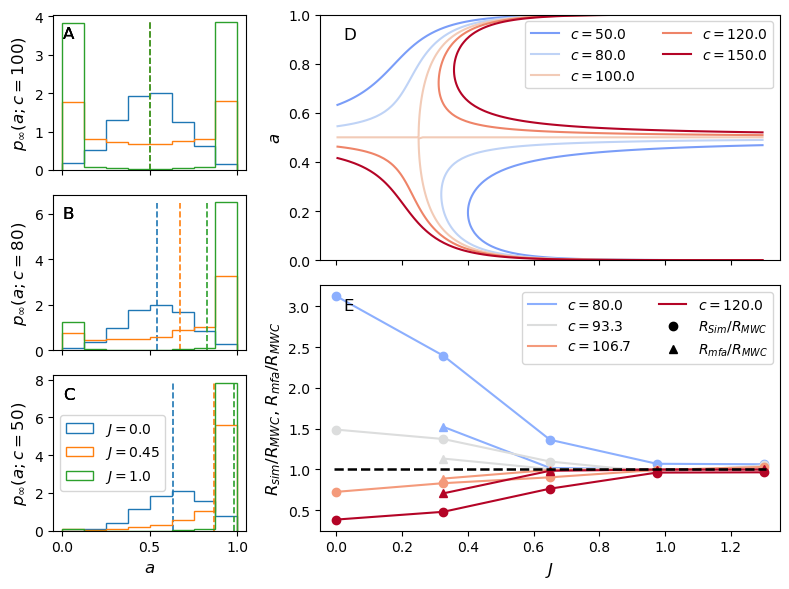

In [7]:
# preparation
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(6, 3)

##############################
## Stationary distributions ##
##############################

ax3 = fig.add_subplot(gs[4:,0])
ax1 = fig.add_subplot(gs[0:2,0],sharex=ax3)
ax2 = fig.add_subplot(gs[2:4,0],sharex=ax3)

colormap_aux = matplotlib.colormaps.get_cmap('tab10')

# parameters
n_samples = 5000
tf = 4000
L = 3
N = L**2
cbase = 100
n_steps = 10**3

J_arr = np.array([0.,0.45,1.])
c_arr = np.array([100.,80.,50.])
text_list = ['A','B','C']

# for various J in absence of external field
for i,ax in enumerate((ax1, ax2, ax3)):
    for j,J in enumerate(J_arr):
        # set concentration and color
        c = c_arr[i]
        color = colormap_aux(j)
        
        # extract an ensemble of states
        all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_states[:,-1,:,:],axis=(1,2))
        
        # plot distributions along with mean
        ax.hist(last_act,bins=8,density=True,histtype='step',color=color,label=f'$J={J}$')
        ax.axvline(x=np.mean(last_act),ymin=0.0,ymax=0.95,ls='--',color=color,linewidth=1.2)
        ax.text(0.05,0.85,text_list[i],size=12,transform = ax.transAxes)
        
    ax.set_ylabel(r'$p_\infty(a; c = '+str(int(c))+')$',size=12)

# formatting
ax3.legend(fontsize=10,loc='center left')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.set_xlabel(r'$a$',size=12)

#########################
## Bifurcation diagram ##
#########################

ax5 = fig.add_subplot(gs[3:,1:])
ax4 = fig.add_subplot(gs[0:3,1:],sharex=ax5)

# reset the coupling strengths and concentrations
c_arr = np.array([50.,80.,100.,120.,150.])
J_arr = np.linspace(0.,1.3,5)

# show the bifurcation diagram of the mean-field Ising model
m = np.linspace(-1,1,100)
J = np.linspace(J_arr[0],J_arr[-1],100)
m, J = np.meshgrid(m, J)

# transform to activity
a = 0.5*m + 0.5
handles = []

# solve the src for various c
for i,c in enumerate(c_arr):
    # set color
    color = colormap((i+0.99)/c_arr.size)
    cmap = matplotlib.colors.ListedColormap([color,color])
    
    # solve the self-consistency relation
    z = scr(m,J,c)
    ax4.contour(J, a, z, levels=[0], cmap=cmap)
    
    # legend formatting
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))

# formatting
ax4.legend(handles=handles,fontsize=10,ncol=2)
ax4.set_ylabel(r'$a$',size=12)
ax4.text(0.05,0.9,'D',size=12,transform = ax4.transAxes)
plt.setp(ax4.get_xticklabels(), visible=False)

#################
## Convergence ##
#################

# perform for various c
c_arr = np.linspace(80.,120.,4)

# store results
ratio_sim = np.zeros((c_arr.size,J_arr.size),dtype='float32')
ratio_mfa_arr = np.zeros_like(ratio_sim)
handles = []

for i,c in enumerate(c_arr):
    # set a color and format legend
    color = colormap((i+0.99)/c_arr.size)
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))
    
    # increase J systematically
    for j,J in enumerate(J_arr):
        # extract an ensemble of states
        all_states,_,_ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_states[:,-1,:,:],axis=(1,2))

        # estimate the ratio
        ratio_sim[i,j] = np.sum(last_act < 0.5)/np.sum(last_act > 0.5)
        ratio_mfa_arr[i,j] = ratio_mfa(J,c,N)

    # check where the mfa ratio is well-defined
    mask = ratio_mfa_arr[i,:] >= 0.
    
    # show ratio of ratios for both sim and mfa
    ax5.plot(J_arr,ratio_sim[i,:]/mwc_ratio(c,N=N),'-o',color=color)
    ax5.plot(J_arr[mask],ratio_mfa_arr[i,mask]/mwc_ratio(c,N=N),'-^',color=color)

# formatting
handles.append(Line2D([], [], color='k', marker='o', linestyle='None', label=r'$R_{Sim}/R_{MWC}$'))
handles.append(Line2D([], [], color='k', marker='^', linestyle='None', label=r'$R_{mfa}/R_{MWC}$'))

ax5.legend(handles=handles,fontsize=10,ncol=2)
ax5.set_xlabel(r'$J$',size=12)
ax5.set_ylabel(r'$R_{sim}/R_{MWC}$, $R_{mfa}/R_{MWC}$',size=12)
ax5.set_xlim(J_arr[0]-0.05,J_arr[-1]+0.05)
ax5.text(0.05,0.9,'E',size=12,transform = ax5.transAxes)
ax5.axhline(y=1,xmin=0.03,xmax=0.97,ls='--',color='k',linewidth=1.8)

plt.tight_layout()
plt.show()

In [6]:
@numba.jit(nopython=True)
def dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr):
    # set when the concentration is changed
    step_change = 1000

    # store results
    all_responses = np.zeros((J_arr.size,cnew_arr.size,L_arr.size),dtype='float32')
    all_var = np.zeros_like(all_responses,dtype='float32')

    # perform simulation for various L, J and cnew
    for k,L in enumerate(L_arr):
        # update number of samples
        n_samples_L = n_samples//L
        #loop through various coupling strengths
        for i,J in enumerate(J_arr):
            # loop for various new concentrations
            for j, c_new in enumerate(cnew_arr):
                # obtain results
                all_states, ensemble_av, _ = ensemble_averaged_ising(n_samples_L,n_steps,tf,L,J,
                                                                          step_change=step_change,cnew=c_new)
                
                # extract ensemble variance on the activity; note the prefactor!
                ensemble_var = np.zeros((n_steps,L,L),dtype='float32')
                for step in range(n_steps):
                    for spin1 in range(L):
                        for spin2 in range(L):
                            ensemble_var[step,spin1,spin2] = 0.25*np.var(all_states[:,step,spin1,spin2])

                # extract activity, weird numba way
                av_spin = np.sum(np.sum(ensemble_av,axis=-1),axis=-1)/L**2
                activity = 0.5*(av_spin + 1)

                # set baseline and extract new equilibrium
                baseline = np.mean(activity[500:step_change-1]) # remove transient
                new_act = np.mean(activity[-1000:])
                
                # save response
                all_responses[i,j,k] = new_act - baseline
                
                # calculate error in the response, assuming a_pre and a_post have uncorrelated errors
                ens_var_baseline = np.mean(ensemble_var[500:step_change-1])/ensemble_var[500:step_change-1].size
                ens_var_new = np.mean(ensemble_var[-1000:])/ensemble_var[-1000:].size
                
                var_baseline = np.var(activity[500:step_change-1])
                var_new = np.var(activity[-1000:])
                
                # save errors
                all_var[i,j,k] = ens_var_baseline + ens_var_new + var_baseline + var_new

        print('Done for L = ', L)
            
    return all_responses, all_var

# define Hill function
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5)

# function to compute theoretical drc based on MWC model
def theoretical_drc(cnew_arr,N,ampl):
    # fix some parameters
    c0 = 100
    delta_f = -2
    Ki = 18
    Ka = 2900
    
    # adequately set initial methylation
    mbase = N/2.
    m0 = mbase - (N/delta_f)*np.log((1+100/18)/(1+100/2900))
    
    # calculate free-energy difference
    f0 = N*np.log((1 + c0/Ki)/(1 + c0/Ka)) + delta_f*(m0 - mbase)
    fc = N*np.log((1 + cnew_arr/Ki)/(1 + cnew_arr/Ka)) + delta_f*(m0 - mbase)
    
    # calculate average activities
    a_pre = 1/(1 + np.exp(f0))
    a_post = 1/(1 + np.exp(fc))
    
    # return response
    return ampl*(a_post-a_pre)

In [9]:
# make a meshgrid for plotting
J_arr = np.linspace(0,0.45,7)
cnew_arr = np.logspace(-0.5,4.5,25)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 2*10**3
n_steps = 4000
tf = 2*10**3
L_arr = np.array([2,4,8])

# extract dose-response curves
all_responses, all_var = dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr)

Done for L =  2
Done for L =  4
Done for L =  8


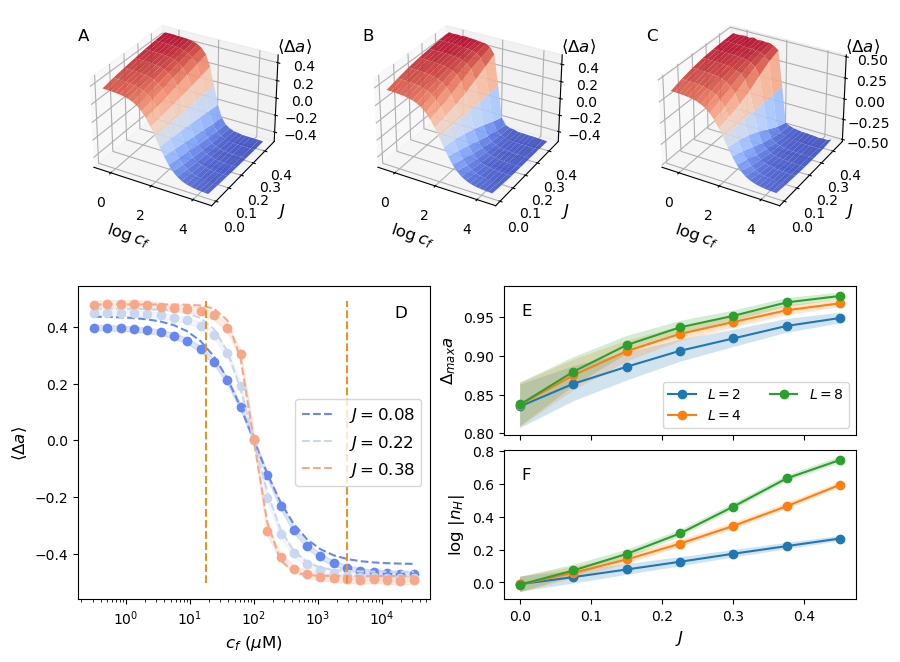

In [10]:
# preparation
fig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(6, 6)

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

##############
## 3D plots ##
##############

ax1 = fig.add_subplot(gs[:2,:2], projection='3d')

ax2 = fig.add_subplot(gs[:2,2:4], projection='3d')

ax3 = fig.add_subplot(gs[:2,4:], projection='3d')

text_list = ['A','B','C']
for k,ax in enumerate((ax1,ax2,ax3)):
    ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses[:,:,k],cmap=plt.cm.coolwarm,alpha=0.9)
    ax.set_xlabel(r'$\log c_f$',size=12)
    ax.set_ylabel('$J$',size=12)
    ax.text2D(0.95,0.8,r'$\langle \Delta a \rangle$',size=12,transform = ax.transAxes)
    ax.text2D(0,0.85,text_list[k],size=12,transform = ax.transAxes)

#################
## Projections ##
#################

ax4 = fig.add_subplot(gs[2:4,:3])

# perform fitting
parm_arr = np.zeros((2,J_arr.size,L_arr.size))
var_arr = np.zeros_like(parm_arr)

for k in range(L_arr.size):
    for j in range(J_arr.size):
        popt, pcov = curve_fit(hill_func_max,cnew_arr,all_responses[j,:,k],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,k]))
        parm_arr[:,j,k] = popt
        var_arr[:,j,k] = [pcov[l,l] for l in range(2)]

        # visual inspection for some results
        if (j+1) % 2 == 0 and k == 1:
            # set color
            color = colormap(j/J_arr.size)
            
            # plots
            ax4.semilogx(cnew_arr,all_responses[j,:,k],'o',color=color)
            ax4.fill_between(cnew_arr,all_responses[j,:,k]-np.sqrt(all_var[j,:,k]),
                             all_responses[j,:,k]+np.sqrt(all_var[j,:,k]),color=color,alpha=0.2)
            ax4.semilogx(cnew_arr,hill_func_max(cnew_arr,*popt),'--',
                         color=color,label=f'$J={np.round(J_arr[j],2)}$')

# figure formatting
ax4.axvline(x=18,ymin=0.05,ymax=0.95,linestyle='--',color=my_yellow)
ax4.axvline(x=2900,ymin=0.05,ymax=0.95,linestyle='--',color=my_yellow)
ax4.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax4.set_ylabel(r'$\langle \Delta a \rangle$',size=12)
ax4.legend(fontsize=12)
ax4.text(0.9,0.9,'D',size=12,transform = ax4.transAxes)

#####################
## Hill parameters ##
#####################

ax5 = fig.add_subplot(gs[2,3:])
ax6 = fig.add_subplot(gs[3,3:],sharex=ax5)

# transform errors on absolute Hill coefficient (propagation of errors)
var_hill = var_arr[1,:,:]
var_loghill = var_hill/(np.log(10)*parm_arr[1,:,:])**2

# mark measurement errors
mask = var_loghill > 1
var_loghill[mask] = 0 

# show fitting parameters for various L
for k in range(L_arr.size):
    ax5.plot(J_arr,-1*parm_arr[0,:,k],'-o',label=f'$L={L_arr[k]}$')
    ax5.fill_between(J_arr,-1*parm_arr[0,:,k]+np.sqrt(var_arr[0,:,k]),
                     -1*parm_arr[0,:,k]-np.sqrt(var_arr[0,:,k]),alpha=0.2)
    ax6.plot(J_arr,np.log10(np.abs(parm_arr[1,:,k])),'-o',label=f'$L={L_arr[k]}$')
    ax6.fill_between(J_arr,np.log10(np.abs(parm_arr[1,:,k]))-np.sqrt(var_loghill[:,k]),
                     np.log10(np.abs(parm_arr[1,:,k]))+np.sqrt(var_loghill[:,k]),alpha=0.2)

# formatting
ax5.set_ylabel(r'$\Delta_{max} a$',size=12)
ax5.text(0.05,0.8,'E',size=12,transform = ax5.transAxes)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.legend(fontsize=10,ncol=2,loc='lower right')

ax6.set_ylabel(r'log $|n_H|$',size=12)
ax6.set_xlabel('$J$',size=12)
ax6.text(0.05,0.8,'F',size=12,transform = ax6.transAxes)

plt.tight_layout()
plt.subplots_adjust(wspace=1.1, hspace=0.1)

plt.show()

In [55]:
# make a meshgrid for plotting
J_arr = np.linspace(0,0.5,6)
cnew_arr = np.logspace(-0.5,4.5,25)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 10**2 # change to 10**3
n_steps = 4000
tf = 2*10**3
#L_arr = np.arange(2,9,1)
L_arr = np.array([6]) # use the above line

# extract dose-response curves
all_responses, all_var = dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr)

Done for L =  5


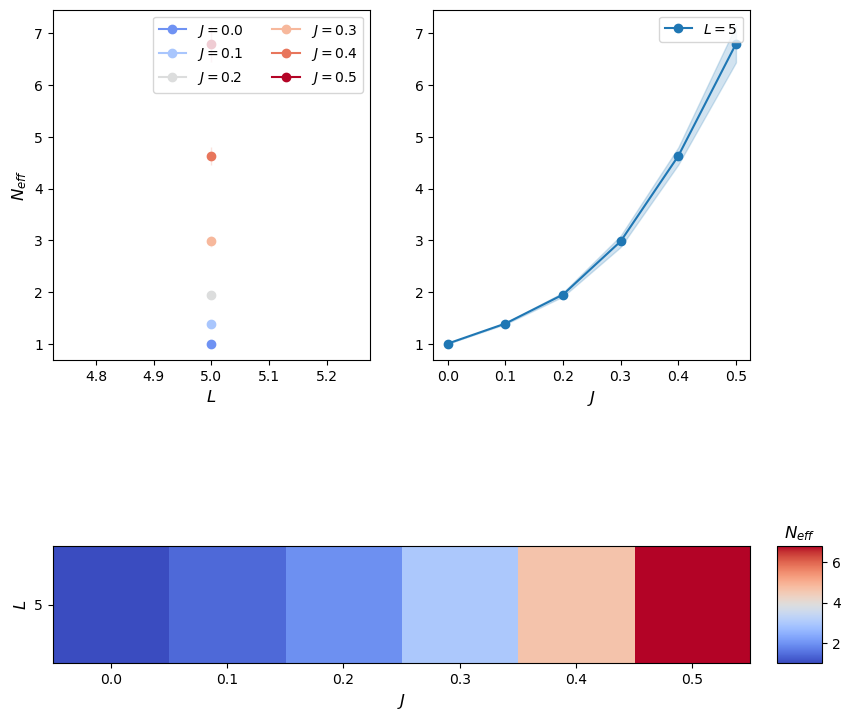

In [56]:
# array to store results
parm_hm_arr = np.zeros((2,J_arr.size,L_arr.size),dtype='float32')
var_hm_arr = np.zeros_like(parm_hm_arr)

# extract Neff for various L and J
for j,J in enumerate(J_arr):
    for l,L in enumerate(L_arr):
        # perform fitting
        popt, pcov = curve_fit(theoretical_drc,cnew_arr,all_responses[j,:,l],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,l]))
        
        # store results
        parm_hm_arr[:,j,l] = popt
        var_hm_arr[:,j,l] = [pcov[i,i] for i in range(2)]
        
# preparation
fig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])


for j, J in enumerate(J_arr):
    color = colormap((j+0.99)/J_arr.size)
    ax1.plot(L_arr,parm_hm_arr[0,j,:],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax1.fill_between(L_arr,parm_hm_arr[0,j,:]-np.sqrt(var_hm_arr[0,j,:]),
                     parm_hm_arr[0,j,:]+np.sqrt(var_hm_arr[0,j,:]),color=color,alpha=0.2)

#plt.plot(L_arr,L_arr**2,ls='--',label=r'$J\to \infty$')
ax1.set_xlabel(r'$L$',size=12)
ax1.set_ylabel(r'$N_{eff}$',size=12)
ax1.legend(fontsize=10,ncol=2)

for l, L in enumerate(L_arr):
    color = colormap_aux(l)
    ax2.plot(J_arr,parm_hm_arr[0,:,l],'-o',color=color,label=f'$L={L}$')
    ax2.fill_between(J_arr,parm_hm_arr[0,:,l]-np.sqrt(var_hm_arr[0,:,l]),
                     parm_hm_arr[0,:,l]+np.sqrt(var_hm_arr[0,:,l]),color=color,alpha=0.2)

#plt.plot(L_arr,L_arr**2,ls='--',label=r'$J\to \infty$')
ax2.set_xlabel(r'$J$',size=12)
ax2.legend(fontsize=10,ncol=2)

im = ax3.imshow(parm_hm_arr[0,:,:].T,cmap=plt.cm.coolwarm)
ax3.set_xticks(range(len(J_arr)), np.round(J_arr,2))
ax3.set_yticks(range(len(L_arr)), L_arr)
ax3.invert_yaxis()
ax3.set_xlabel(f'$J$',size=12)
ax3.set_ylabel(f'$L$',size=12)

# formatting the colorbar
cax = fig.add_axes([ax3.get_position().x1+0.03,ax3.get_position().y0,0.05,ax3.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title(r'$N_{eff}$',size=12)

plt.show()

Expected N for a gain of G=1.73: 8.968433486442425


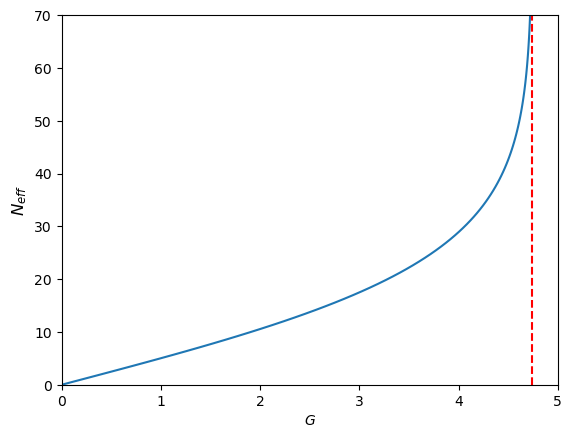

In [23]:
def Neff_eq(Neff,G,c0=100,cf=90,Ki=18,Ka=2900):
    # define epsilon0 as per usual
    epsilon0 = -Neff*np.log((1+c0/Ki)/(1+c0/Ka))
    
    # define free-energy differences
    F = epsilon0 + Neff*np.log((1+cf/Ki)/(1+cf/Ka))
    
    # activity change
    Delta_a = 1/(1+np.exp(F)) - 0.5
    
    # return equation for the gain G
    return G-Delta_a/np.log(c0/cf)

# show what you would expect based on Mattingly's data
G = 1.73
root = fsolve(Neff_eq,[1],args=(G))
print('Expected N for a gain of G=1.73:', root[0])

# solve the equation for Neff
G_plt = np.linspace(0,5,100)
N_plt = np.linspace(0,70,100)
N_plt, G_plt = np.meshgrid(N_plt, G_plt)
eq = Neff_eq(N_plt,G_plt)

plt.contour(G_plt,N_plt, eq, levels=[0],cmap='tab10')
plt.axvline(x=0.5/np.log(100/90),ymin=0.,ymax=1,ls='--',color='r')
plt.ylabel(r'$N_{eff}$',size=12)
plt.xlabel(r'$G$')
plt.show()

In [14]:
# obtain an Ising lattice
# parameters
n_samples = 10**2
n_steps = 2000
tf = 500
L = 8
c = 100
J = 0.

# extract an ensemble of states
all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

# consider only the last time step of each realisation
last_state = 0.5 + 0.5*all_states[:,-1,:,:]

In [39]:
# function for calculating the correlation function of an ensemble of lattices
@numba.jit(nopython=True)
def corr_function(n_repeats,last_state,L):
    # prepare arrays
    corr_func = np.zeros((n_repeats,L//2),dtype='float32')
    r_arr = np.arange(0,L//2,1)

    # randomly choose n_repeats spins on the lattice
    for rep in range(n_repeats):
        # randomly sample a spin on the lattice
        x,y = np.random.randint(0,L,size=2)

        # find activity at position x,y
        axy = last_state[:,x,y]
        axy_av = np.mean(axy)
        
        # consider all possible displacements
        for r in r_arr:
            counter = 0
            all_aiaj = 0
            all_aisq = 0
        
        # define the state of all the neighbours, if they exist
        # also add the relevant terms for the correlation function
            if x-r > -1:
                left = last_state[:,x-r,y]
                all_aisq = axy_av*np.mean(left)
                all_aiaj += np.mean(axy*left)
                counter += 1
            if x+r < L:
                right = last_state[:,x+r,y]
                all_aisq += axy_av*np.mean(right)
                all_aiaj += np.mean(axy*right)
                counter += 1
            if y-r > -1:
                top = last_state[:,x,y-r]
                all_aisq += axy_av*np.mean(top)
                all_aiaj += np.mean(axy*top)
                counter += 1
            if y+r < L:
                bottom = last_state[:,x,y+r]
                all_aisq += axy_av*np.mean(bottom)
                all_aiaj += np.mean(axy*bottom)
                counter += 1
            
            # calculate the correlation between the spin and its neighbours, given 
            # the spin has at least one neighbour at a distance r
            if counter > 0:
                corr_func[rep,r] = (all_aiaj-all_aisq)/counter
            ########## Check what is sensible to do here
            
    return corr_func, r_arr

In [37]:
# perform an exponential fit
def exp_fit(data,var_a,rho):
    return var_a*np.exp(-data/rho)

# obtain correlation function
n_repeats = 10**2
corr_func, r_arr = corr_function(n_repeats,last_state,L)

popt,pcov = curve_fit(exp_fit,r_arr,np.mean(corr_func,axis=0),sigma=np.std(corr_func,axis=0))

print('correlation length:', popt[-1])

plt.plot(r_arr,np.mean(corr_func,axis=0),'o')
plt.fill_between(r_arr,np.mean(corr_func,axis=0)-np.std(corr_func,axis=0),
                 np.mean(corr_func,axis=0)+np.std(corr_func,axis=0),alpha=0.2)
plt.plot(r_arr,exp_fit(r_arr,*popt))

plt.xlabel(r'$r$',size=12)
plt.ylabel(r'$g(r)$',size=12)
plt.show()

/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


ValueError: operands could not be broadcast together with shapes (2,) (5,) 

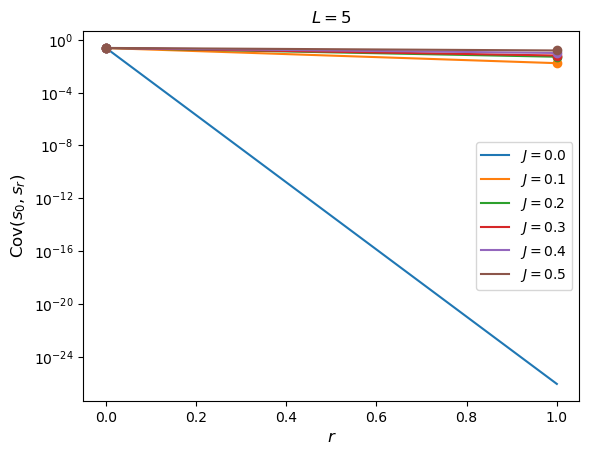

In [62]:
n_samples = 50
n_steps = 2000
tf = 500
c = 100
n_repeats = 50

# define sizes
L_arr = np.array([5])

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L_arr[-1])

# define below-critical coupling strengths
J_arr = np.linspace(0.,0.5,6)

# arrays to store results
parm_corr = np.zeros((2,L_arr.size,J_arr.size),dtype='float32')
var_corr = np.zeros_like(parm_corr)

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # extract an ensemble of states
        all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

        # consider only the last time step of each realisation
        last_state = 0.5 + 0.5*all_states[:,-1,:,:]

        # extract correlation function
        corr_func,r_arr = corr_function(n_repeats,last_state,L)

        popt, pcov = curve_fit(exp_fit,r_arr,np.mean(corr_func,axis=0),sigma=np.std(corr_func,axis=0))
        parm_corr[:,l,j] = popt
        var_corr[:,l,j] = [pcov[i,i] for i in range(2)]
        
        # check that the fit is reasonable
        color = colormap_aux(j)
        plt.plot(r_arr,np.mean(corr_func,axis=0),'o',color=color)
        plt.plot(r_arr,exp_fit(r_arr,*popt),color=color,label=f'$J={np.round(J,2)}$')
        
    plt.xlabel(r'$r$',size=12)
    plt.ylabel(r'Cov$(s_0, s_r)$',size=12)
    plt.yscale('log')
    plt.legend()
    plt.title(f'$L={L}$')
    plt.show()

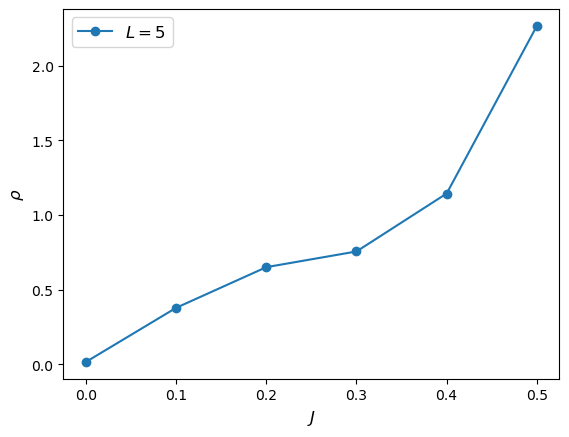

In [64]:
# show results
for l,L in enumerate(L_arr):
    plt.plot(J_arr,parm_corr[1,l,:],'-o',label=f'$L={L}$')
    #plt.fill_between(J_arr,parm_corr[1,l,:]-np.sqrt(var_corr[1,l,:]),parm_corr[1,l,:]+np.sqrt(var_corr[1,l,:])
    #                ,alpha=0.2)
#plt.axhline(y=L/2,xmin=0.05,xmax=0.95,ls='--',color=my_red)
#plt.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,ls='--',color=my_red)
plt.xlabel(r'$J$',size=12)
plt.ylabel(r'$\rho$',size=12)
plt.legend(fontsize=12)
plt.show()

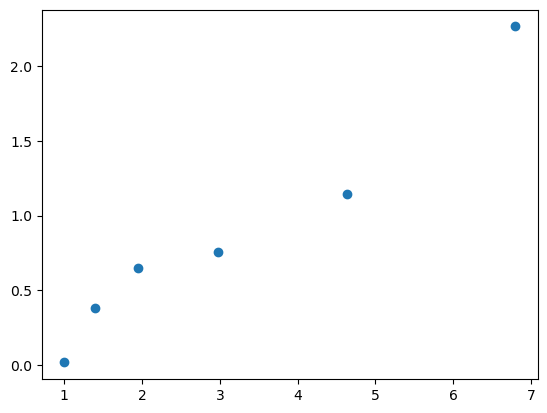

In [69]:
plt.plot(parm_hm_arr[0,:,l],parm_corr[1,0,:],'o')
plt.show()

In [8]:
####################
#################### Make sure everything makes sense here

# function for determining the spatial cross-correlations of a given state
def cross_correlation(state):
    # shift the origin and subtract mean to ultimately get covariance
    ########## should I subtract lattice mean or ensemble mean?
    shifted_state = fftpack.fftshift(state-np.mean(state))
    
    # take Fourier transform
    ft = fftpack.fft2(shifted_state)

    # compute power spectrum
    ps = np.abs(ft)**2

    # compute inverse of power spectrum, i.e. the cross-correlation
    cc_shifted = np.real(fftpack.ifft2(ps))

    # shift the origin back
    cc = fftpack.fftshift(cc_shifted)

    # normalise
    cc_max = np.max(cc)
    cc_norm = cc/np.max(cc)
    
    # extract position of the origin, i.e. where the correlation is max.
    x0,y0 = np.unravel_index(np.argmax(cc),cc.shape)
    
    return cc_norm,x0,y0

Three ways to estimate correlation length from an ensemble of states:
- obtain cc for each state and estimate rho from those, get a distribution of rho and then take mean
- obtain cc for each state, average these ccs (like ensemble average), estimate rho
- obtain cc for ensemble-averaged state and obtain rho from there

What is the best one?

/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


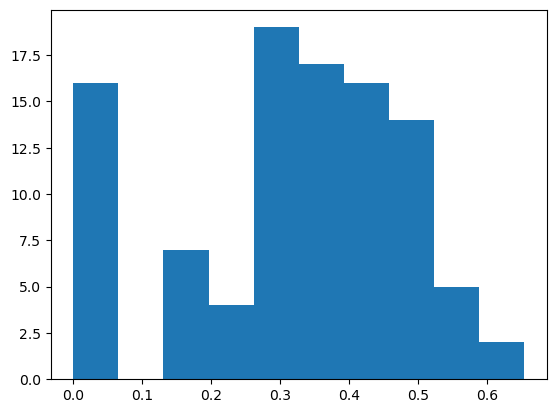

Proportion of lattices where procedure was successful: 1.0
Mean correlation distance: 0.31957405715312


In [17]:
def exp_2d(xy,rho):
    x,y = xy
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    return np.exp(-r/rho)

J = 0.1
n_samples = 10**2
n_steps = 2000
tf = 500
c = 100
n_repeats = 50

# extract an ensemble of states
all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

# prepare fitting
x = np.arange(0,L,1)
y = np.arange(0,L,1)
X,Y = np.meshgrid(x,y)


for i in range(n_samples):
    state = all_states[i,-1,:,:]
    cc_norm,x0,y0 = cross_correlation(state)
    
    if x0 == 5 and y0 == 5:
        rho_opt,_ = curve_fit(exp_2d,(np.reshape(X,X.size),np.reshape(Y,Y.size)),
                                 np.reshape(cc_norm,cc_norm.size))

        if i == 0:
            all_rho = np.array([rho_opt[0]])
        else:
            all_rho = np.append(all_rho,rho_opt[0])
            
plt.hist(all_rho)
plt.show()

print('Proportion of lattices where procedure was successful:', all_rho.size/n_samples)
print('Mean correlation distance:',np.mean(all_rho))

/tmp/ipykernel_2711502/2135273496.py:24: RuntimeWarning: invalid value encountered in divide
  cc_norm = cc/np.max(cc)


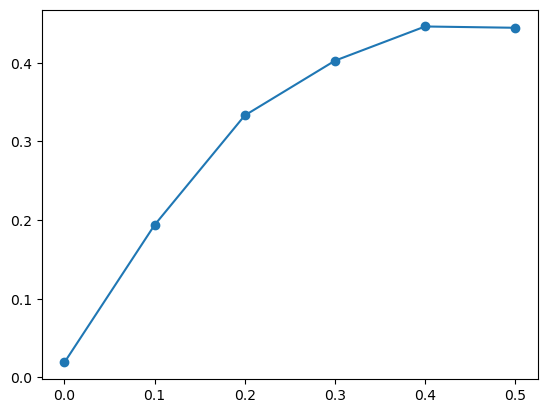

In [58]:
n_samples = 200
n_steps = 2000
tf = 400
c = 100

# define sizes
L = 5

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# define below-critical coupling strengths
J_arr = np.linspace(0,0.5,6)
all_rho = np.zeros_like(J_arr)

# prepare fitting
x = np.arange(0,L,1)
y = np.arange(0,L,1)
X,Y = np.meshgrid(x,y)

for j,J in enumerate(J_arr):
    all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)
    for i in range(n_samples):
        state = all_states[i,-1,:,:]
        cc_norm,x0,y0 = cross_correlation(state)

        if x0 == L//2 and y0 == L//2:
            if i == 0:
                all_cc = np.array([cc_norm])
            else:
                all_cc = np.concatenate((all_cc,[cc_norm]))
            
    mean_cc = np.mean(all_cc,axis=0)

    rho_opt,rho_var = curve_fit(exp_2d,(np.reshape(X,X.size),np.reshape(Y,Y.size)),
                                 np.reshape(mean_cc,mean_cc.size))
    
    all_rho[j] = rho_opt[0]

plt.plot(J_arr,all_rho,'-o')
#plt.axvline(x=J_crit_fin,ymin=0.03,ymax=0.97,ls='--',color='red')
plt.show()

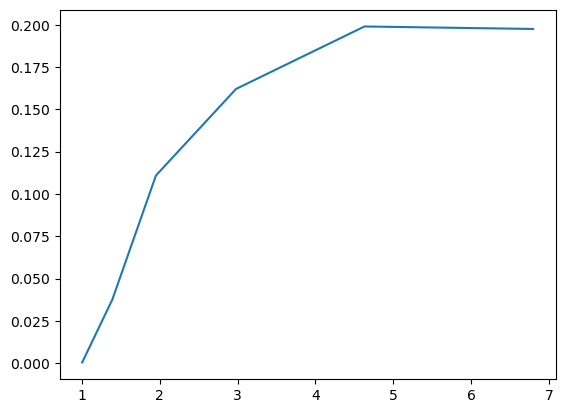

In [61]:
plt.plot(parm_hm_arr[0,:,0],all_rho**2)
plt.show()

In [19]:
av_state = np.mean(all_states[:,-1,:,:],axis=0)

cc_norm, x0, y0 = cross_correlation(av_state)

rho_opt,rho_var = curve_fit(exp_2d,(np.reshape(X,X.size),np.reshape(Y,Y.size)),
                                 np.reshape(cc_norm,cc_norm.size))

print(rho_opt,rho_var)

[0.42798943] [[0.0070817]]


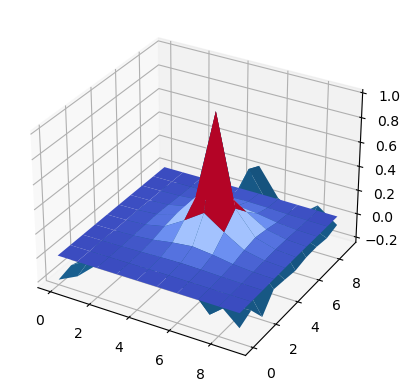

[0.73890856] [[0.00584069]]


In [16]:
def exp_2d(xy,rho):
    x,y = xy
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    return np.exp(-r/rho)

x = np.arange(0,L,1)
y = np.arange(0,L,1)

test_popt, test_pcov = curve_fit(exp_2d,(np.reshape(X,X.size),np.reshape(Y,Y.size)),
                                 np.reshape(cc_norm,cc_norm.size))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, cc_norm)
ax.plot_surface(X, Y, exp_2d((X,Y),*test_popt),cmap=plt.cm.coolwarm)
plt.show()

print(test_popt,test_pcov)